In [1]:
# Import Library
%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# Prepare and Review Dataset

In [2]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Costruisco le immagini

[5503.7    0.  6993.  7891.4    0.  5255.9 6056.8 7754.3 8344.2 4936.4]


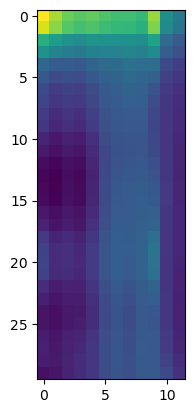

In [3]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

max = allPixel3.max()
min = allPixel3.min()
training_set = []
test_set = []
choice = np.random.choice(range(allPixel3.shape[0]), size=(790,), replace=False)
ind = np.zeros(allPixel3.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind
training_setX = allPixel3[ind,:,:]
training_setY = newResa3[ind]
training_setX = np.array(training_setX)
training_setY = np.array(training_setY)

test_setX = allPixel3[rest,:,:]
test_setY = newResa3[rest]
test_setX = np.array(test_setX)
test_setY = np.array(test_setY)

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [4]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/training_setY.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/test_setY.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (32,32),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (32,32),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.115171
1  1.tiff  0.187392
2  2.tiff  0.185063
3  3.tiff  0.003252
4  4.tiff  0.200996
Found 790 validated image filenames.
Found 789 validated image filenames.


In [5]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.26362675428390503
0.2608710527420044
0.27094337344169617
0.27312996983528137


# Creazione del modello di Vgg16

In [6]:
# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

# Import model
#vgg16 = VGG16()

In [7]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [8]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)-1):
    vgg16Model.add(vgg16_layer_list[i])

In [9]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [10]:
# Last layer
#vgg16Model.add(Dense(units=1))

vgg16Model.add(Dense(units=1))

In [11]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [12]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Training Model 

In [13]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 10,
                                validation_data=test_data
                                )

Epoch 1/10
25/25 [==============================] - 5s 173ms/step - loss: 0.0844 - mse: 0.0844 - mae: 0.2098 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0948
Epoch 2/10
25/25 [==============================] - 4s 162ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0746 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0929
Epoch 3/10
25/25 [==============================] - 4s 161ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0678 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0635
Epoch 4/10
25/25 [==============================] - 4s 158ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0644 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0703
Epoch 5/10
25/25 [==============================] - 4s 157ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0614 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0601
Epoch 6/10
25/25 [==============================] - 4s 156ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0630 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0585
Epoch 7/10
25/25

In [14]:
# Save the weights of model
vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

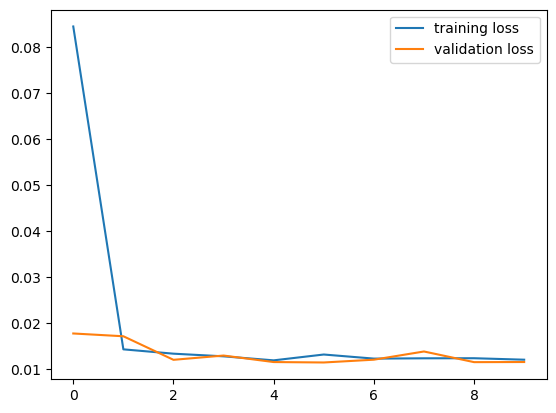

In [15]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

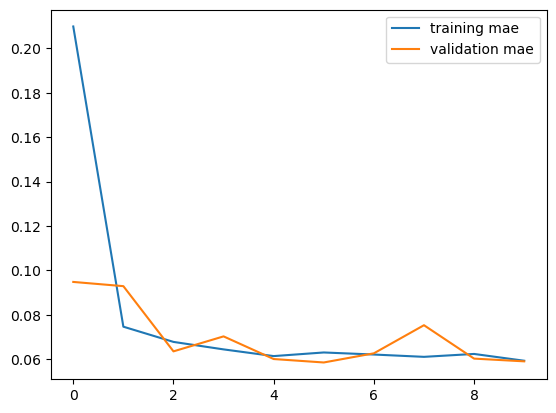

In [31]:
# mae e val mae
plt.plot(hist_vgg16.history["mae"], label = "training mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [16]:
import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [17]:
with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [18]:
load_result

{'loss': [0.0844399556517601,
  0.014210737310349941,
  0.013267287984490395,
  0.012688735499978065,
  0.011816967278718948,
  0.01308476086705923,
  0.012194804847240448,
  0.012260437943041325,
  0.012278043664991856,
  0.011957979761064053],
 'mse': [0.0844399556517601,
  0.014210737310349941,
  0.013267287984490395,
  0.012688735499978065,
  0.011816967278718948,
  0.01308476086705923,
  0.012194804847240448,
  0.012260437943041325,
  0.012278043664991856,
  0.011957979761064053],
 'mae': [0.20981192588806152,
  0.0746292918920517,
  0.06777667999267578,
  0.06440647691488266,
  0.06138705089688301,
  0.06301872432231903,
  0.06208916753530502,
  0.06104874983429909,
  0.06235367804765701,
  0.05929495766758919],
 'val_loss': [0.017660999670624733,
  0.017054883763194084,
  0.011932410299777985,
  0.01286035031080246,
  0.011446380987763405,
  0.011353249661624432,
  0.011960550211369991,
  0.013744095340371132,
  0.011426158249378204,
  0.011452504433691502],
 'val_mse': [0.01766

# Vgg19

In [20]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [21]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [22]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [23]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [24]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [25]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [26]:
# Last layer
vgg19Model.add(Dense(1))

In [27]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [28]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Addestramento

In [29]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 10,
                               validation_data = test_data
                               )

Epoch 1/10
25/25 [==============================] - 6s 205ms/step - loss: 0.2055 - mse: 0.2055 - mae: 0.3307 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1103
Epoch 2/10
25/25 [==============================] - 5s 191ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0890 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0765
Epoch 3/10
25/25 [==============================] - 5s 197ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0747 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0750
Epoch 4/10
25/25 [==============================] - 5s 192ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0742 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0678
Epoch 5/10
25/25 [==============================] - 5s 192ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0689 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0661
Epoch 6/10
25/25 [==============================] - 5s 195ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0715 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.0721
Epoch 7/10
25/25

# Visualizziamo i risultati ottenuti

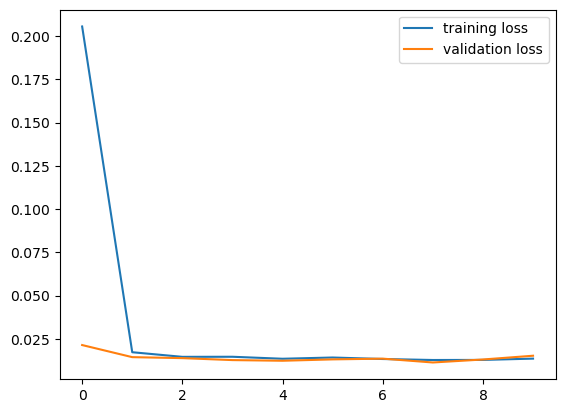

In [30]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

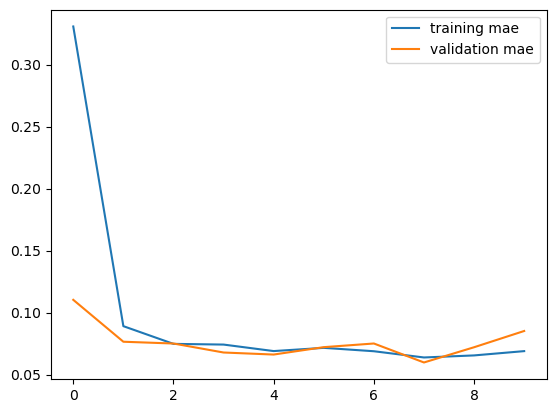

In [32]:
# mae e val mae
plt.plot(hisy_vgg19.history["mae"], label = "training mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()